# <center>CMPBIO210, IB120, IB201
# <center>"Introduction to Quantitative Methods in Biology"
# <center>Lecture 9. ODE Model of Glucose Homeostasis
## <center>Denis Titov

**The goal of this jupyter notebook is to discuss how to formulate, solve and analyze ODE model of human glucose homeostasis**

Optional additional resources:  
  
*Karin et al. Dynamical compensation in physiological circuits. Molecular Systems Biology (2016).*
https://doi.org/10.15252/msb.20167216  

*Topp et al. A model of beta-cell mass, insulin, and glucose kinetics: pathways to diabetes. Journal of Theoretical Biology (2000).*  
https://doi.org/10.1006/jtbi.2000.2150

In [2]:
import numpy as np
import sympy as sym
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

## Simplest Insulin-Glucose Circuit

Thes simplest model of glucose homeostasis is a system of two ODEs:
    
$\frac{dGlucose}{dt}= meal - s \cdot Insulin \cdot Glucose$  

$\frac{dInsulin}{dt}= q \cdot B \cdot \frac{Glucose^2}{K^2 + Glucose^2} - \gamma \cdot Insulin$  

where $meal$ is the amount of glucose in the meal, $s$ is the sensitivity of glucose uptake to insulin, $q$ is the rate of insulin secretion, $B$ is the mass of beta cells, $\gamma$ is the rate of insulin degradation, and $K$ is a constant that determines the shape of the insulin secretion curve. The model can be analyzed using numerical methods to simulate the dynamics of insulin and glucose levels over time.

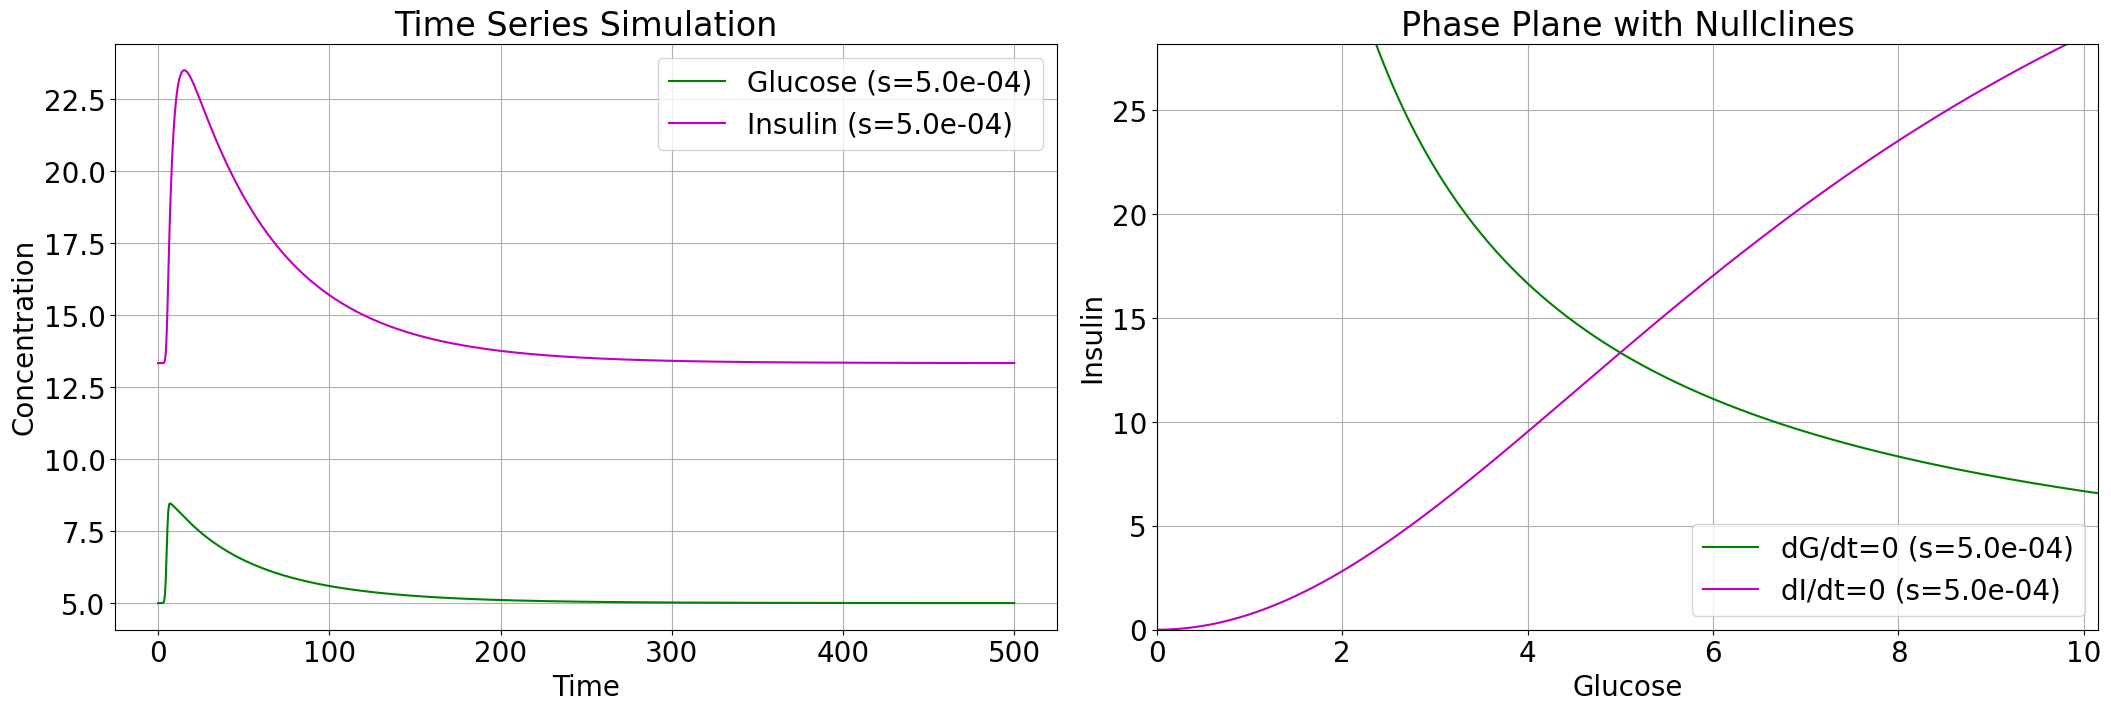

In [69]:
# Update default font size for plots (approx 2x default)
plt.rcParams.update({'font.size': 20})

# Parameters from Karin et al. 2016
m = 1/30 # mM min-1
gamma = 0.3 #min-1
s_orig = 5e-4 # ml µU-1 min-1
q = 0.03 # µU ml-1 min-1
K = 7.85 # mM
mu = 0.000015 #min-1
Gst = 5 # mM
beta_st = gamma * m * (Gst**2 + K**2) / (q * s_orig * Gst**3)

# ODE function
def InsulinGlucoseSimple(t, y, current_s):
    Glucose, Insulin = y
    meal_dynamic = m + 2 * np.exp(-(t - 5)**2)
    dGlucosetdt = meal_dynamic - current_s * Glucose * Insulin
    dInsulindt = q * beta_st * (Glucose**2) / (Glucose**2 + K**2) - gamma * Insulin
    return [dGlucosetdt, dInsulindt]

# --- Simulation Setup ---
s_values = [s_orig] # Only use the original s value
colors = {'Glucose': 'g', 'Insulin': 'm', 'Trajectory': 'k'}
tspan = [0, 500]
t_eval = np.linspace(tspan[0], tspan[1], 1000)

solutions = []
steady_states = []

# --- Run Simulations ---
for s_val in s_values:
    # Calculate steady state for current s
    insulin_st = m / (Gst * s_val)
    steady_states.append({'s': s_val, 'insulin_st': insulin_st})
    
    # Initial conditions
    initial_condition = [Gst, insulin_st]
    
    # Solve ODE
    soln = solve_ivp(
        InsulinGlucoseSimple, tspan, initial_condition,
        args=(s_val,),
        t_eval=t_eval,
        atol=1e-10, rtol=1e-10,
    )
    solutions.append(soln)

# --- Plotting ---
# Determine plot limits
glucose_max_all = max(np.max(sol.y[0]) for sol in solutions) * 1.2
insulin_max_all = max(np.max(sol.y[1]) for sol in solutions) * 1.2
glucose_min, glucose_max = 0, glucose_max_all
insulin_min, insulin_max = 0, insulin_max_all

# Initialize figure
fig, axs = plt.subplots(1, 2, figsize=(21, 7), dpi=100, constrained_layout=True)

# Plot Time Series (axs[0])
soln_orig = solutions[0]
s_val_orig = steady_states[0]['s']
axs[0].plot(soln_orig.t, soln_orig.y[0], color=colors['Glucose'], label=f"Glucose (s={s_val_orig:.1e})")
axs[0].plot(soln_orig.t, soln_orig.y[1], color=colors['Insulin'], label=f"Insulin (s={s_val_orig:.1e})")

axs[0].set_xlabel("Time")
axs[0].set_ylabel("Concentration")
axs[0].set_title("Time Series Simulation")
axs[0].legend()
axs[0].grid(True)

# Plot Phase Plane (axs[1])
G_null_range = np.linspace(1e-6, glucose_max, 500)
# Nullclines for s_orig
I_null_glucose = m / (s_val_orig * G_null_range)
I_null_insulin = (q * beta_st / gamma) * (G_null_range**2) / (K**2 + G_null_range**2)
axs[1].plot(G_null_range, I_null_glucose, color=colors['Glucose'], label=f'dG/dt=0 (s={s_val_orig:.1e})')
axs[1].plot(G_null_range, I_null_insulin, color=colors['Insulin'], label=f'dI/dt=0 (s={s_val_orig:.1e})')
    
axs[1].set_xlabel("Glucose")
axs[1].set_ylabel("Insulin")
axs[1].set_title("Phase Plane with Nullclines")
axs[1].legend()
axs[1].set_xlim([glucose_min, glucose_max])
axs[1].set_ylim([insulin_min, insulin_max])
axs[1].grid(True)

plt.show()

In [70]:
# Define symbolic variables
G, I = sym.symbols('G, I', real=True, positive=True) # Glucose and Insulin
m, s, q, B, K, gamma = sym.symbols('m, s, q, B, K, gamma', positive=True) # Parameters

# Define the equations for steady state (derivatives = 0)
# Assuming a constant meal input 'm' for steady state analysis
eq1 = sym.Eq(m - s * I * G, 0)
eq2 = sym.Eq(q * B * (G**2 / (K**2)) - gamma * I, 0)

# Solve the system of equations for G and I
steady_state_solutions = sym.nonlinsolve([eq1, eq2], [G, I], )

# Display the solutions
print("Steady state solutions (Glucose, Insulin):")
steady_state_solutions

Steady state solutions (Glucose, Insulin):


{(K**(2/3)*gamma**(1/3)*m**(1/3)/(B**(1/3)*q**(1/3)*s**(1/3)), B**(1/3)*m**(2/3)*q**(1/3)/(K**(2/3)*gamma**(1/3)*s**(2/3))), (K**(2/3)*gamma**(1/3)*m**(1/3)*(-1 - sqrt(3)*I)/(2*B**(1/3)*q**(1/3)*s**(1/3)), -B**(1/3)*m**(2/3)*q**(1/3)/(2*K**(2/3)*gamma**(1/3)*s**(2/3)) + sqrt(3)*I*B**(1/3)*m**(2/3)*q**(1/3)/(2*K**(2/3)*gamma**(1/3)*s**(2/3))), (K**(2/3)*gamma**(1/3)*m**(1/3)*(-1 + sqrt(3)*I)/(2*B**(1/3)*q**(1/3)*s**(1/3)), -B**(1/3)*m**(2/3)*q**(1/3)/(2*K**(2/3)*gamma**(1/3)*s**(2/3)) - sqrt(3)*I*B**(1/3)*m**(2/3)*q**(1/3)/(2*K**(2/3)*gamma**(1/3)*s**(2/3)))}

## Let's investigate the effect of $s$ on Simplest Insulin-Glucose Circuit

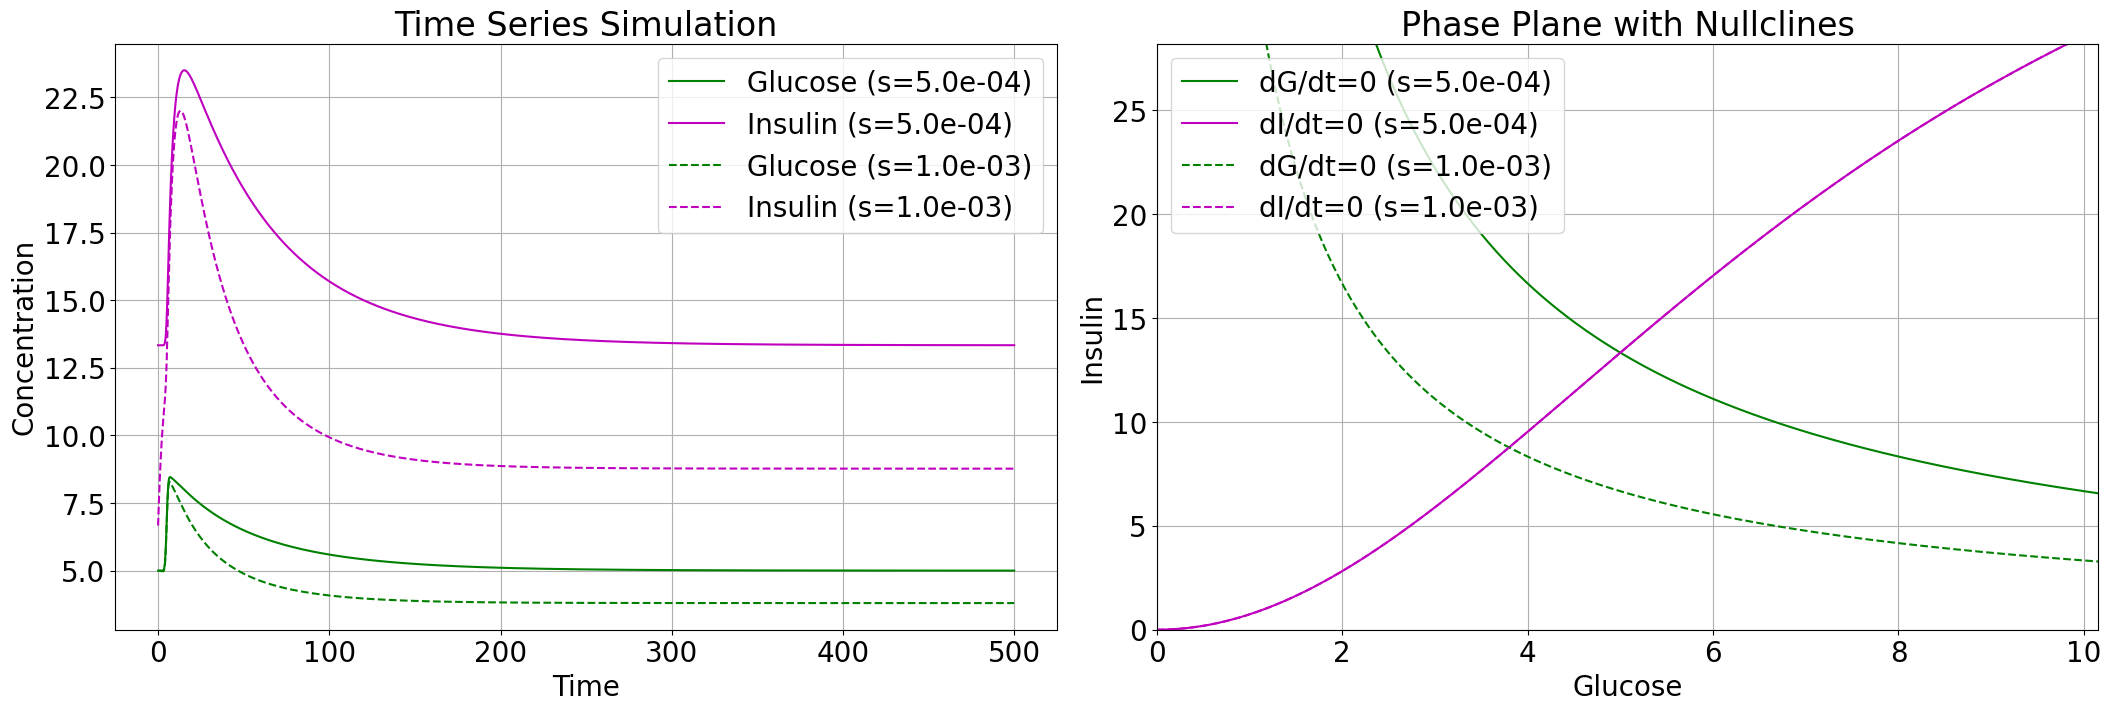

In [71]:
# Update default font size for plots (approx 2x default)
plt.rcParams.update({'font.size': 20})

# Parameters from Karin et al. 2016
m = 1/30 # mM min-1
gamma = 0.3 #min-1
s_orig = 5e-4 # ml µU-1 min-1
q = 0.03 # µU ml-1 min-1
K = 7.85 # mM
mu = 0.000015 #min-1
Gst = 5 # mM
beta_st = gamma * m * (Gst**2 + K**2) / (q * s_orig * Gst**3)

# ODE function
def InsulinGlucoseSimple(t, y, current_s):
    Glucose, Insulin = y
    meal_dynamic = m + 2 * np.exp(-(t - 5)**2)
    dGlucosetdt = meal_dynamic - current_s * Glucose * Insulin
    dInsulindt = q * beta_st * (Glucose**2) / (Glucose**2 + K**2) - gamma * Insulin
    return [dGlucosetdt, dInsulindt]

# --- Simulation Setup ---
s_values = [s_orig, s_orig * 2]
linestyles = ['-', '--']
colors = {'Glucose': 'g', 'Insulin': 'm', 'Trajectory': 'k'}
tspan = [0, 500]
t_eval = np.linspace(tspan[0], tspan[1], 1000)

solutions = []
steady_states = []

# --- Run Simulations ---
for s_val in s_values:
    # Calculate steady state for current s
    insulin_st = m / (Gst * s_val)
    steady_states.append({'s': s_val, 'insulin_st': insulin_st})
    
    # Initial conditions
    initial_condition = [Gst, insulin_st]
    
    # Solve ODE
    soln = solve_ivp(
        InsulinGlucoseSimple, tspan, initial_condition,
        args=(s_val,),
        t_eval=t_eval,
        atol=1e-10, rtol=1e-10,
    )
    solutions.append(soln)

# --- Plotting ---
# Determine plot limits
glucose_max_all = max(np.max(sol.y[0]) for sol in solutions) * 1.2
insulin_max_all = max(np.max(sol.y[1]) for sol in solutions) * 1.2
glucose_min, glucose_max = 0, glucose_max_all
insulin_min, insulin_max = 0, insulin_max_all

# Initialize figure
fig, axs = plt.subplots(1, 2, figsize=(21, 7), dpi=100, constrained_layout=True)

# Plot Time Series (axs[0])
for i, soln in enumerate(solutions):
    s_val = steady_states[i]['s']
    ls = linestyles[i]
    axs[0].plot(soln.t, soln.y[0], color=colors['Glucose'], linestyle=ls, label=f"Glucose (s={s_val:.1e})")
    axs[0].plot(soln.t, soln.y[1], color=colors['Insulin'], linestyle=ls, label=f"Insulin (s={s_val:.1e})")

axs[0].set_xlabel("Time")
axs[0].set_ylabel("Concentration")
axs[0].set_title("Time Series Simulation")
axs[0].legend()
axs[0].grid(True)

# Plot Phase Plane (axs[1])
G_null_range = np.linspace(1e-6, glucose_max, 500)
for i, soln in enumerate(solutions):
    s_val = steady_states[i]['s']
    ls = linestyles[i]
    
    # Nullclines
    I_null_glucose = m / (s_val * G_null_range)
    I_null_insulin = (q * beta_st / gamma) * (G_null_range**2) / (K**2 + G_null_range**2)
    axs[1].plot(G_null_range, I_null_glucose, color=colors['Glucose'], linestyle=ls, label=f'dG/dt=0 (s={s_val:.1e})')
    axs[1].plot(G_null_range, I_null_insulin, color=colors['Insulin'], linestyle=ls, label=f'dI/dt=0 (s={s_val:.1e})')
    
axs[1].set_xlabel("Glucose")
axs[1].set_ylabel("Insulin")
axs[1].set_title("Phase Plane with Nullclines")
axs[1].legend()
axs[1].set_xlim([glucose_min, glucose_max])
axs[1].set_ylim([insulin_min, insulin_max])
axs[1].grid(True)

plt.show()

## Insulin-Glucose Circuit with variable beta cell mass
The model can be extended to include the dynamics of beta cell mass, which can change in response to insulin levels. The modified system of ODEs is as follows:

The simplest model of glucose homeostasis is a system of three ODEs:
    
$\frac{dGlucose}{dt}= meal - s \cdot Insulin \cdot Glucose$  

$\frac{dInsulin}{dt}= q \cdot B \cdot \frac{Glucose^2}{K^2 + Glucose^2} - \gamma \cdot Insulin$  

$\frac{dBetaMass}{dt}= \mu \cdot (Glucose - Gst)$  

where $meal$ is the amount of glucose in the meal, $s$ is the sensitivity of glucose uptake to insulin, $q$ is the rate of insulin secretion, $B$ is the mass of beta cells, $\gamma$ is the rate of insulin degradation, $K$ is a constant that determines the shape of the insulin secretion curve, and $\mu$ is the rate of change of beta cell mass. The model can be analyzed using numerical methods to simulate the dynamics of insulin and glucose levels over time, as well as the impact of varying beta cell mass on overall glucose homeostasis, including the effects of insulin feedback on beta cell dynamics.

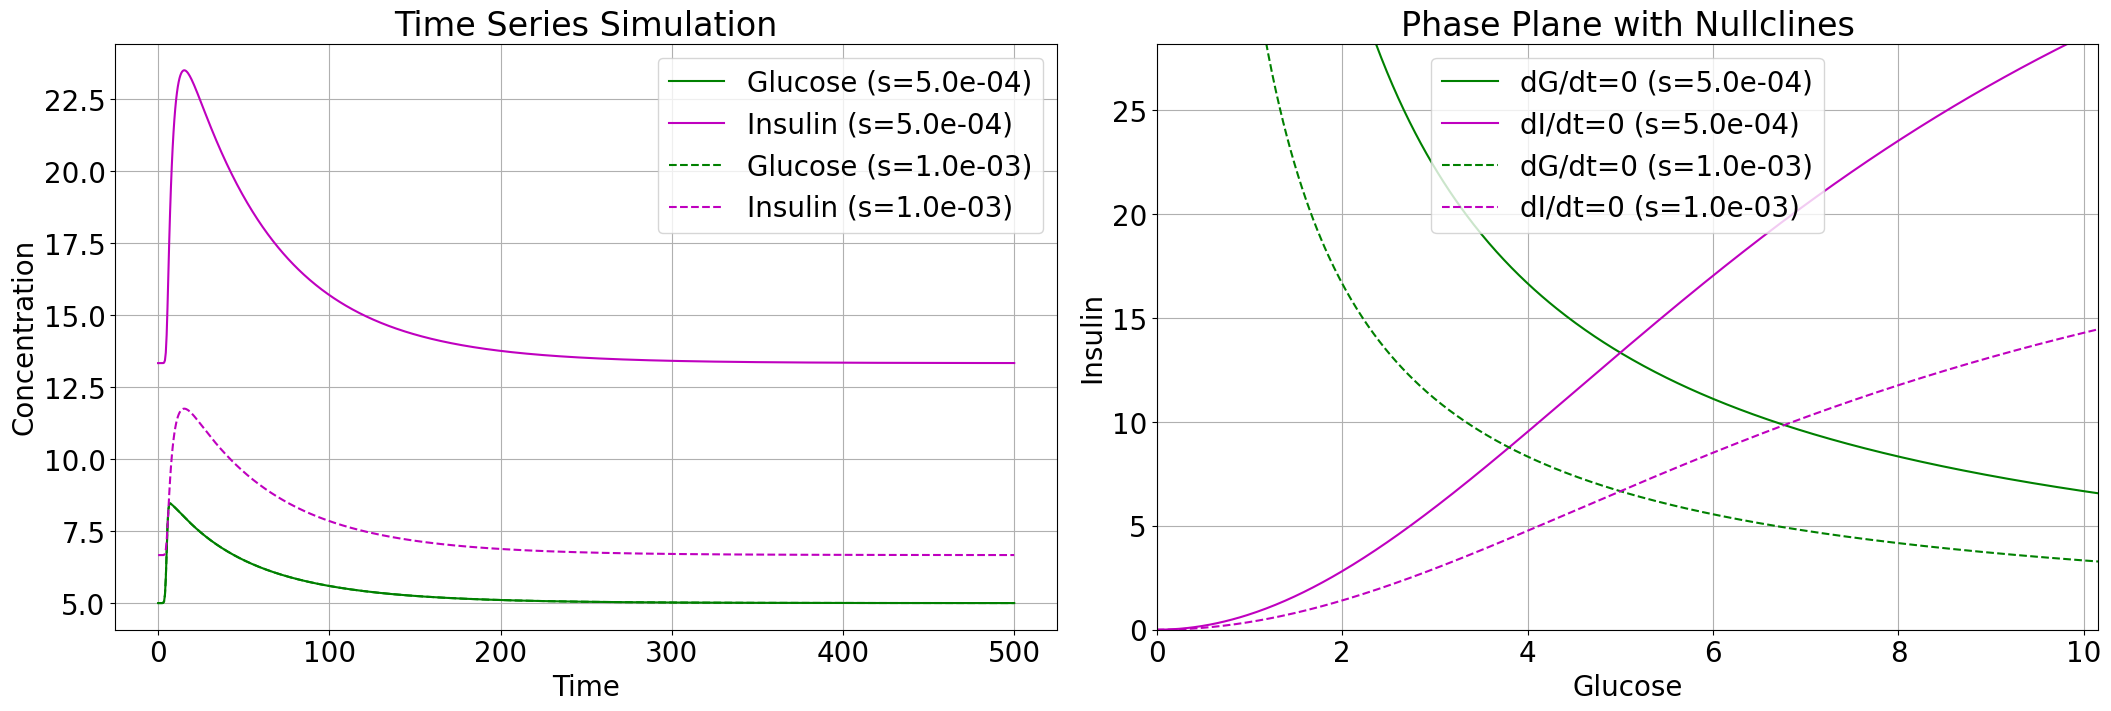

In [74]:
# Update default font size for plots (approx 2x default)
plt.rcParams.update({'font.size': 20})

# Parameters from Karin et al. 2016
m = 1/30 # mM min-1
gamma = 0.3 #min-1
s_orig = 5e-4 # ml µU-1 min-1
q = 0.03 # µU ml-1 min-1
K = 7.85 # mM
mu = 0.000015 #min-1
Gst = 5 # mM

# ODE function
def InsulinGlucoseSimple(t, y, current_s):
    Glucose, Insulin, BetaMass = y
    meal_dynamic = m + 2 * np.exp(-(t - 5)**2)
    dGlucosetdt = meal_dynamic - current_s * Glucose * Insulin
    dInsulindt = q * BetaMass * (Glucose**2) / (Glucose**2 + K**2) - gamma * Insulin
    dBetaMassdt = mu * (Glucose - Gst)
    return [dGlucosetdt, dInsulindt, dBetaMassdt]

# --- Simulation Setup ---
s_values = [s_orig, s_orig * 2]
linestyles = ['-', '--']
colors = {'Glucose': 'g', 'Insulin': 'm', 'BetaCellMass': 'k'}
tspan = [0, 500]
t_eval = np.linspace(tspan[0], tspan[1], 1000)

solutions = []
steady_states = []

# --- Run Simulations ---
for s_val in s_values:
    # Calculate steady state for current s
    beta_st = gamma * m * (Gst**2 + K**2) / (q * s_val * Gst**3)
    insulin_st = m / (Gst * s_val)
    steady_states.append({'s': s_val, 'beta_st': beta_st, 'insulin_st': insulin_st})
    
    # Initial conditions
    initial_condition = [Gst, insulin_st, beta_st]
    
    # Solve ODE
    soln = solve_ivp(
        InsulinGlucoseSimple, tspan, initial_condition,
        args=(s_val,),
        t_eval=t_eval,
        atol=1e-10, rtol=1e-10,
    )
    solutions.append(soln)

# --- Plotting ---
# Determine plot limits
glucose_max_all = max(np.max(sol.y[0]) for sol in solutions) * 1.2
insulin_max_all = max(np.max(sol.y[1]) for sol in solutions) * 1.2
glucose_min, glucose_max = 0, glucose_max_all
insulin_min, insulin_max = 0, insulin_max_all

# Initialize figure
fig, axs = plt.subplots(1, 2, figsize=(21, 7), dpi=100, constrained_layout=True)

# Plot Time Series (axs[0])
for i, soln in enumerate(solutions):
    s_val = steady_states[i]['s']
    ls = linestyles[i]
    axs[0].plot(soln.t, soln.y[0], color=colors['Glucose'], linestyle=ls, label=f"Glucose (s={s_val:.1e})")
    axs[0].plot(soln.t, soln.y[1], color=colors['Insulin'], linestyle=ls, label=f"Insulin (s={s_val:.1e})")
    # axs[0].plot(soln.t, soln.y[2], color=colors['BetaCellMass'], linestyle=ls, label=f"Beta Mass (s={s_val:.1e})")

axs[0].set_xlabel("Time")
axs[0].set_ylabel("Concentration")
axs[0].set_title("Time Series Simulation")
axs[0].legend()
axs[0].grid(True)

# Plot Phase Plane (axs[1])
G_null_range = np.linspace(1e-6, glucose_max, 500)
for i, soln in enumerate(solutions):
    s_val = steady_states[i]['s']
    beta_st_val = steady_states[i]['beta_st']
    ls = linestyles[i]
    
    # Nullclines
    I_null_glucose = m / (s_val * G_null_range)
    I_null_insulin = (q * beta_st_val / gamma) * (G_null_range**2) / (K**2 + G_null_range**2)
    axs[1].plot(G_null_range, I_null_glucose, color=colors['Glucose'], linestyle=ls, label=f'dG/dt=0 (s={s_val:.1e})')
    axs[1].plot(G_null_range, I_null_insulin, color=colors['Insulin'], linestyle=ls, label=f'dI/dt=0 (s={s_val:.1e})')
    
axs[1].set_xlabel("Glucose")
axs[1].set_ylabel("Insulin")
axs[1].set_title("Phase Plane with Nullclines")
axs[1].legend()
axs[1].set_xlim([glucose_min, glucose_max])
axs[1].set_ylim([insulin_min, insulin_max])
axs[1].grid(True)

plt.show()

In [32]:
# Define symbolic variables
G, I, B = sym.symbols('G, I, B', real=True, positive=True) # Glucose and Insulin
m, s, q, K, gamma, Gst = sym.symbols('m, s, q, K, gamma, G_st', positive=True) # Parameters

# Define the equations for steady state (derivatives = 0)
# Assuming a constant meal input 'm' for steady state analysis
eq1 = sym.Eq(m - s * I * G, 0)
eq2 = sym.Eq(q * B * (G**2 / (K**2 + G**2)) - gamma * I, 0)
eq3 = sym.Eq(mu * B *(G - Gst), 0)

# Solve the system of equations for G, I, and B
steady_state_solutions = sym.nonlinsolve([eq1, eq2, eq3], [G, I, B], )

# Display the solutions
print("Steady state solutions (Glucose, Insulin, B):")
steady_state_solutions

Steady state solutions (Glucose, Insulin, B):


{(G_st, m/(G_st*s), gamma*m/(G_st**3*q*s))}